In [165]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
import cv2

In [2]:
%matplotlib inline

In [17]:
path = '/scratch/ssd/cciw/sample_data/'
images = os.listdir(path)
#img = images[-3]
#img = '1340_2016-07-11_1_GLN_3447.JPG'
img = '1349_2016-07-06_2_GLN_3061.JPG'
#img = 'sudoku.png'

In [18]:
f = os.path.join(path, img)

In [19]:
im = cv2.imread(f)

In [20]:
im.shape  # (height, width)

(7360, 4912, 3)

In [21]:
#np.sqrt(im.shape[0]**2 + im.shape[1]**2)

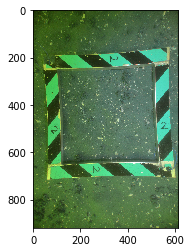

In [22]:
ds = 8  # naive downsampling by factor of 8
plt.imshow(im[::ds, ::ds])

In [46]:
#img = im[::ds, ::ds].astype(np.uint8).copy()
img = np.ascontiguousarray(im[::ds, ::ds], dtype=np.uint8)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # convert to greyscale for edge detection
print(gray.shape)

(920, 614)


In [190]:
from skimage.feature import corner_harris, corner_peaks, corner_subpix

In [201]:
coords = corner_peaks(corner_harris(gray), min_distance=50)
coords_subpix = corner_subpix(gray, coords, window_size=13)
print(coords_subpix)

[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]


In [199]:
coords

array([[175, 441],
       [198, 229],
       [651, 182]])

<IPython.core.display.Javascript object>


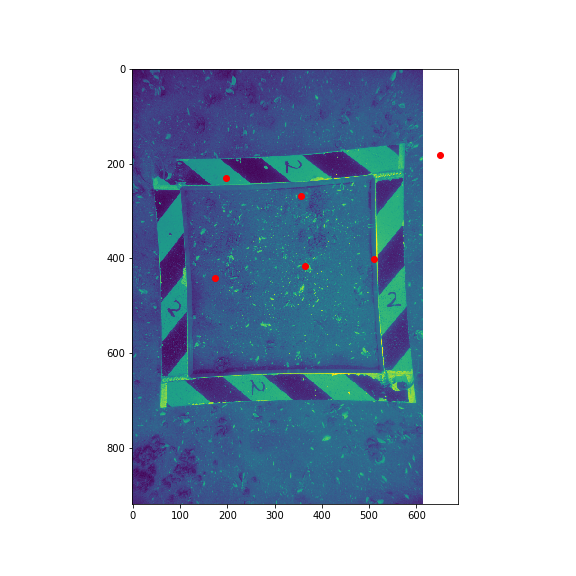

In [196]:
plt.figure(figsize=(8,8))
plt.imshow(gray)
plt.scatter(coords[:, 0], coords[:, 1], c='r')

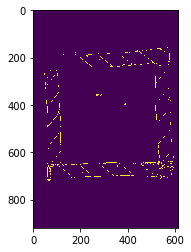

In [40]:
edges = cv2.Canny(gray, 50, 500, L2gradient=True)
plt.imshow(edges)

In [56]:
print(lines[0, 0, 0]) 
print(lines[0, 0, 1] * 180 / np.pi) 

711.0
88.00000017209338


57.29577951308232

In [49]:
cv2.HoughLines?

In [180]:
(180 / np.pi) * np.pi / 3

60.0

In [234]:
r

-29.0

In [261]:
DP_1 = 0
DP_2 = 1
X_COORD = 0
Y_COORD = 1

(6032, 1, 2)
0 2.00
0 (-588, 731) (638, 689)
1 2.00
1 (-590, 675) (636, 632)
2 94.00
2 (-13, -614) (71, 610)
3 2.00
3 (-590, 678) (636, 635)
4 92.00
4 (74, -616) (117, 610)
5 2.00
5 (-606, 216) (620, 173)
6 90.00
6 (572, 614) (572, -614)
7 94.00
7 (498, -650) (584, 574)
8 -2.00
8 (-637, 662) (589, 705)
9 -0.00
9 (-614, 641) (613, 642)


<IPython.core.display.Javascript object>


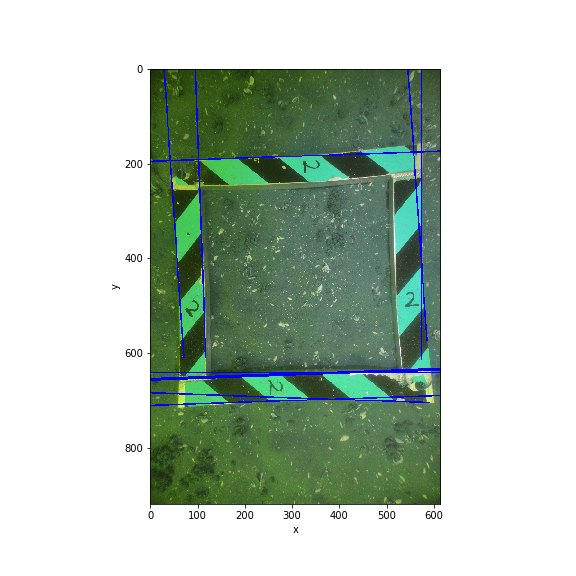

In [277]:
'''
@param rho Distance resolution of the accumulator in pixels.
@param theta Angle resolution of the accumulator in radians.
@param threshold Accumulator threshold parameter. Only those lines are returned that get enough
       votes ( \f$>\texttt{threshold}\f$ ).
@param minLineLength Minimum line length. Line segments shorter than that are rejected.
@param maxLineGap Maximum allowed gap between points on the same line to link them.
'''
#img = im[::ds, ::ds].astype(np.uint8).copy()
img = np.ascontiguousarray(im[::ds, ::ds], dtype=np.uint8)
img_h = img.shape[0]
img_w = img.shape[1]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 100, 500, L2gradient=True)
theta = np.pi / 90  # note, with 180 getting too many overlapping lines.
lines = cv2.HoughLines(edges, 1, theta, 10)

print(lines.shape)  # (N - number of lines found, r - pixels, theta - radians)
#coords = []
N = 10
coords = np.zeros((N, 2, 2)).astype('int') # points, start/end, x/y
angles = np.zeros(N)
for i in range(len(lines[:N])):
    for r, theta in lines[i]:
        # theta is normal to the line wrt x-axis, so we subtract 90
        if r > 0:
            angles[i] = 90 - theta * 180 / np.pi
        else: 
            angles[i] = 270 - theta * 180 / np.pi
        print(i, '%.2f' % angles[i])
        a = np.cos(theta)
        b = np.sin(theta)
        x0, y0 = a * r, b * r
        x1 = int(x0 + img_w * -b)
        y1 = int(y0 + img_w *  a)
        x2 = int(x0 - img_w * -b)
        y2 = int(y0 - img_w *  a)
        #coords.append([[x1, y1], [x2, y2]])
        coords[i, DP_1, X_COORD] = x1
        coords[i, DP_1, Y_COORD] = y1
        coords[i, DP_2, X_COORD] = x2
        coords[i, DP_2, Y_COORD] = y2
        print(i, (x1, y1), (x2, y2))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.xlabel('x')
plt.ylabel('y')
plt.show()        

## Post processing

In [276]:
tol = 5  # tolerance in degrees
ref = angles[0]
candidates = []
candidates.append((0, a))
similar_angles = []
for i, a in enumerate(angles[1:]):
    if a >= ref and ref + tol > a:
        similar_angles.append((i + 1, a))
    else:
        candidates.append((i + 1, a))
print(similar_angles)
print(candidates)

[(1, 1.9999998279066205), (3, 1.9999998279066205)]
[(0, -0.99939084), (2, 93.99999965581324), (4, 91.99999732342846)]


In [272]:
# Of the lines with a similar angle, keep only those that are offset
ref_coord = coords[0]

for i, a in similar_angles:
    if abs(coords[i, DP_1, X_COORD] - ref_coord[DP_1, X_COORD]) > 50:
        print('x-coords differ')
        candidates.append((i, a))
        ref_coord = coords[i]  # update ref_coord
        
    if abs(coords[i, DP_1, Y_COORD] - ref_coord[DP_1, Y_COORD]) > 50:
        print('y-coords differ')
        candidates.append((i, a))
        ref_coord = coords[i]  # update ref_coord

print(candidates)

y-coords differ
[(0, 1.9999998279066205), (2, 93.99999965581324), (1, 1.9999998279066205)]


<IPython.core.display.Javascript object>


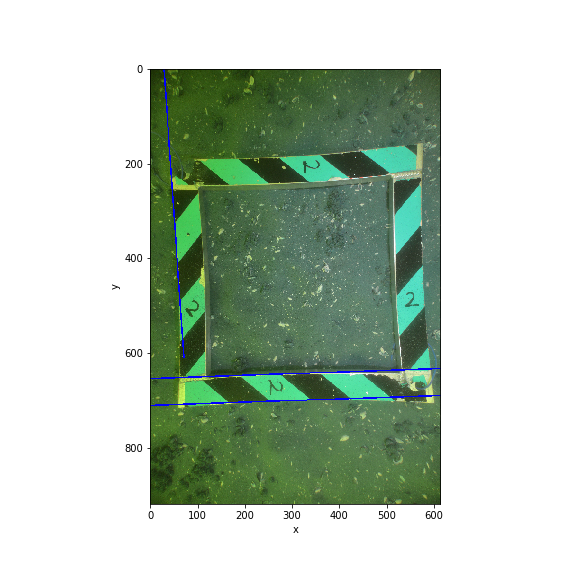

In [274]:
plt.figure(figsize=(8,8))
img = np.ascontiguousarray(im[::ds, ::ds], dtype=np.uint8)
for (i, _) in candidates:
    cv2.line(img, (coords[i, DP_1, X_COORD], coords[i, DP_1, Y_COORD]), 
                  (coords[i, DP_2, X_COORD], coords[i, DP_2, Y_COORD]), (0, 0, 255), 2)
plt.imshow(img)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [124]:
theta = lines[0, 0, 1]

In [141]:
theta

1.5358897

In [160]:
#lines[0,0,1]-np.pi/2

-0.0349065820362906

In [161]:
#t = abs(theta - np.pi / 2)
rot_angle * np.pi / 180
R = np.array([[np.cos(t), -np.sin(t)],
              [np.sin(t),  np.cos(t)]])
coords_r = np.dot(coords, R)

In [163]:
#print(coords)
#coords_r = np.dot(coords, R)
#print(coords_r)

In [164]:
print(coords_r[0, 0, 0]) 
print(coords_r[0, 1, 0])
idx = int((coords_r[0, 0, 0] + coords_r[0, 1, 0]) / 2)
print(idx)

#print(coords_r[2, 0, 0]) 
#print(coords_r[2, 1, 0])
#idx = int((coords_r[2, 0, 0] + coords_r[2, 1, 0]) / 2)
#print(idx)

-562.1302764536277
661.657098864867
49


<IPython.core.display.Javascript object>


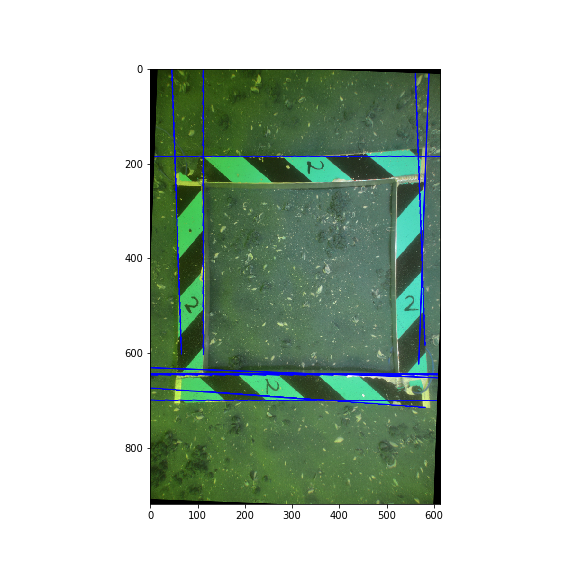

In [167]:
plt.figure(figsize=(8, 8))
#imgr = transform.rotate(img, abs(theta - np.pi/2)*180/np.pi)#.astype(np.uint8)
imgr = transform.rotate(img, -rot_angle)#.astype(np.uint8)
imgr = (255 * imgr).astype(np.uint8)
plt.imshow(imgr[:, :])
plt.show()

In [ ]:
#np.dot()
'''
data = np.random.multivariate_normal(mean=[0, 0], 
                                     cov=np.array([[0.1, 0], [0, 0.001]]), size=1000)

plt.scatter(data[:, 0], data[:, 1])
dr = np.dot(data, R)
plt.scatter(dr[:, 0], dr[:, 1])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
'''

In [ ]:
x0, y0

In [ ]:
run = coords[0][2] - coords[0][0]
rise = coords[0][3] - coords[0][1]
print(rise)
print(run)
print(rise/run)

In [ ]:
#imgr.max()

In [ ]:
#imgr_c.dtype

In [ ]:
imgr_c = img.copy()
gray = cv2.cvtColor(imgr_c, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 100, 500)

In [ ]:
plt.imshow(edges)

In [ ]:
lines = cv2.HoughLinesP(
    edges, rho=1, theta=np.pi/90, threshold=10, minLineLength=300, maxLineGap=70)
print(lines.shape)
hp_coords = np.zeros((N, 2, 2)) # points, start/end, x/y
for i in range(len(lines[:N])):
    for x1,y1,x2,y2 in lines[i]:
        print(x1, y1, x2, y2)
        hp_coords[i, 0, 0] = x1
        hp_coords[i, 0, 1] = y1
        hp_coords[i, 1, 0] = x2
        hp_coords[i, 1, 1] = y2
        cv2.line(imgr_c,(x1,y1),(x2,y2),(0,0,255),2)

In [ ]:
#imgr = skimage.transform.rotate(img, theta * 180/np.pi)
#plt.imshow(imgr[40:380, 330:660])
plt.imshow(imgr_c)